## Foundations of Deep Learning, IAD Minor ##

## Homework 1. Introduction to PyTorch. Fully connected neural networks.


### About the assignment

In this assignment, you are to predict the year of a song's release (**regression task**) from some audio features: [data](https://archive.ics.uci.edu/ml/datasets/yearpredictionmsd). In the boxes below is the code to load the data. Note that the training and test samples are in the same file, so DO NOT change the cell where the data is split.



## Assignment. (maximum 10 points).

Implement the training and testing of a neural network for the data set provided to you. The correlation between the obtained metric value on the test sample and the score for the assignment is as follows:

- $\text{RMSE} \le 9.10 $&mdash; 4 points.
- $\text{RMSE} \le 9.00 $ &mdash; 6 points.
- $\text{RMSE} \le 8.90 $&mdash; 8 points.
- $\text{RMSE} \le 8.80 $&mdash; 10 points.

There are a few rules you need to follow:

- The entire learning pipeline must be written in PyTorch. You can use other libraries (`numpy`, `sklearn`, etc.), but only for data processing. That is, you can transform data and calculate metrics with these libraries as you like, but you cannot import models from `sklearn` and use them to extract the required quality. Also, you cannot use libraries for which PyTorch itself is a dependency.

- We do not limit your choice of model architecture, but most likely a fully-connected neural network will be enough for you.

- It is forbidden to use any data other than the training sample for training.

- Model ensembling is forbidden.



### Useful tips:

- It's very unlikely that you'll be able to knock out a quality score of 10 the first time, so try different architectures, optimizers, and hyperparameter values. Ideally, you should change one thing at the start of each new experiment so you know exactly how that factor affects quality.

- Don't forget that **normalizing the targeting** will help you to improve the quality of the model.

- The fact that we're doing deep learning doesn't mean you should forget about techniques used in classical machine learning. So be sure to perform exploratory data analysis, draw the right graphs, and don't forget about scaling and hyperparameterization.

- You will surely encounter the fact that your neural network will be heavily overtrained. There are special regularization methods for neural networks, such as dropout ([article](https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)) and weight decay ([blogpost](https://towardsdatascience.com/weight-decay-l2-regularization-90a9e17713cd)). They are, of course, implemented in PyTorch. Try experimenting with them.

- If you don't know something, don't hesitate to google it. There is a lot of useful information, tutorials and tips on deep learning in general and on PyTorch in particular. But don't forget that you will have to answer strictly for the rolled code without reference to the source!

- If you implement GPU learning right away, you'll have more time to experiment, as any computations will run faster. Google Colab provides a few GPU hours (usually around 8-10) per day for free.

- To debug your code, you can train on a small portion of data or even a single batches. If the loess on the training sample does not drop, something is definitely going wrong!

- Use the utilities that PyTorch provides you with (for example, Dataset and Dataloader). They were specifically designed to simplify the development of the training pipeline.

- You will most likely want to track the progress of your training. There is a handy `tqdm` library for creating progress bars.

- You might want graphs to be drawn directly during training. You can use the [clear_output](http://ipython.org/ipython-doc/dev/api/generated/IPython.display.html#IPython.display.clear_output) function to delete the old graph and draw a new one in its place.




**NECESSARY** draw graphs of the dependence of loss/metric on the training and test samples depending on the training time. If training takes a relatively small number of epochs, it is better to plot the dependence on the number of training step, if there are more epochs, plot the dependence by epochs. If the checker does not see such a graph for your best model, he/she has the right to lower the score for the assignment.

**IMPORTANT** Your solution must be reproducible. If it is not, the reviewer has the right to lower the grade for the assignment. To fix the random seed, use the function from the previous assignment.



In [2]:
import torch
from torch import nn
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.nn.functional as F
import pandas as pd
import numpy as np
import wandb
import random
device = "cuda" if torch.cuda.is_available() else "cpu"
from tqdm.notebook import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
from sklearn.preprocessing import PowerTransformer

In [3]:
wandb.init(project="pytorch-demo")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: to505to505 (to505to505_team). Use `wandb login --relogin` to force relogin


In [4]:
df = pd.read_csv('data.txt.zip', header=None)
df.head(10)

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903
5,2001,50.54767,0.31568,92.35066,22.38696,-25.51870,-19.04928,20.67345,-5.19943,3.63566,...,6.59753,-50.69577,26.02574,18.94430,-0.33730,6.09352,35.18381,5.00283,-11.02257,0.02263
6,2001,50.57546,33.17843,50.53517,11.55217,-27.24764,-8.78206,-12.04282,-9.53930,28.61811,...,11.63681,25.44182,134.62382,21.51982,8.17570,35.46251,11.57736,4.50056,-4.62739,1.40192
7,2001,48.26892,8.97526,75.23158,24.04945,-16.02105,-14.09491,8.11871,-1.87566,7.46701,...,18.03989,-58.46192,-65.56438,46.99856,-4.09602,56.37650,-18.29975,-0.30633,3.98364,-3.72556
8,2001,49.75468,33.99581,56.73846,2.89581,-2.92429,-26.44413,1.71392,-0.55644,22.08594,...,18.70812,5.20391,-27.75192,17.22100,-0.85210,-15.67150,-26.36257,5.48708,-9.13495,6.08680
9,2007,45.17809,46.34234,-40.65357,-2.47909,1.21253,-0.65302,-6.95536,-12.20040,17.02512,...,-4.36742,-87.55285,-70.79677,76.57355,-7.71727,3.26926,-298.49845,11.49326,-89.21804,-15.09719


In [5]:
device = torch.device("mps")

Мы вывели кусок данных, чтобы понять, насколько они пригодны для работы без изменений. Здесь ясно, что сомнительно дальше с такими данными работать, потому что как минимум есть отрицательные значения, которые не отмасштабированы, кроме того еще сразу бросается в глаза совсем разная размерность, где-то видим реально большие числа, а где-то 0.075. Ясно, что будем скейлить.

In [6]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

In [7]:
y_train = y_train.reshape(-1, 1)
y_test= y_test.reshape(-1, 1)

In [8]:
len(y_test)

51630

In [9]:
pt = PowerTransformer(standardize=True, method='yeo-johnson')
pt.fit(y_train)
y_train = pt.transform(y_train.astype('float64'))
y_test = pt.transform(y_test.astype('float64'))

/Users/dmitrii_sakharov/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:239: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/dmitrii_sakharov/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:250: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


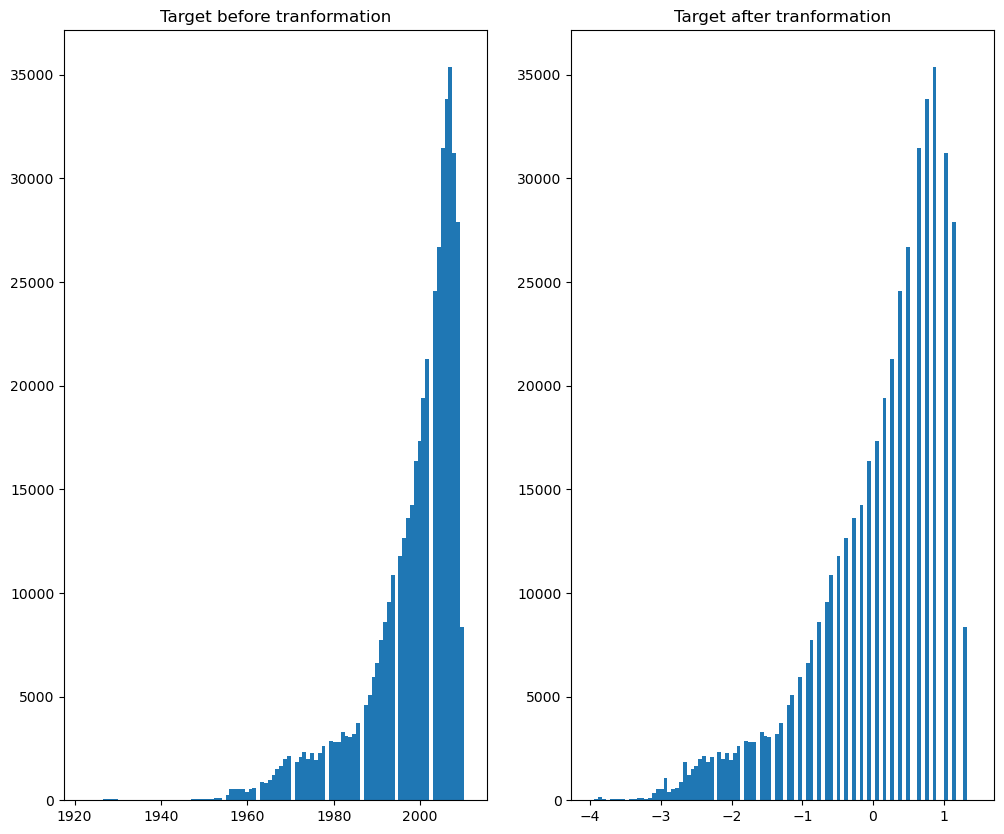

In [14]:
fig = plt.figure(figsize=(12,10))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.hist(y[:train_size], bins=100)
ax1.set_title("Target before tranformation")
ax2.hist(y_train, bins=100,)
ax2.set_title("Target after tranformation")
plt.show()

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

scaler = StandardScaler()

In [16]:
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


In [574]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

### Data

In [575]:
class myDataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return self.x.shape[0]
    
    def __getitem__(self, idx):
        return torch.tensor(self.x[idx, :], dtype=torch.float), self.y[idx]

In [576]:
X_tr = torch.tensor(X_train)
X_tst = torch.tensor(X_test)
Y_tr = torch.tensor(y_train)
Y_tst = torch.tensor(y_test)

data = myDataset(X_tr, Y_tr)
data_test = myDataset(X_tst, Y_tst)

dataloader = torch.utils.data.DataLoader(data, batch_size=20000)
dataloader_test = torch.utils.data.DataLoader(data_test, batch_size=51630)


### Model

In [639]:

class MyModel(nn.Module):
    def __init__(self, input_size, device):
        super(MyModel, self).__init__()
        self.device = device
        self.layer1 = nn.Linear(input_size, 350)
        init.xavier_uniform_(self.layer1.weight)
        self.bn1 = nn.BatchNorm1d(350)
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)
        self.layer2 = nn.Linear(350, 200)
        self.bn2 = nn.BatchNorm1d(200)
        self.relu = nn.ReLU()
        self.dropout2 = nn.Dropout(0.5, inplace=False)
        self.layer3 = nn.Linear(200, 1)
        # Если используете ReLU перед последним слоем
        init.kaiming_uniform_(self.layer3.weight, nonlinearity='relu')

    def forward(self, x):

        x = self.layer1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout1(x)
        x = self.layer2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout2(x)
        x = self.layer3(x)
        return x

In [640]:
input_size = X_tr.shape[1]
model = MyModel(input_size, device)

### Training

In [643]:
x_val, y_val = next(iter(dataloader_test))
x_val = x_val.float().to(device) 
y_val = y_val.float().to(device) 

/var/folders/wn/vk7vt0j13lgf017ktpdypywr0000gn/T/ipykernel_21887/1995826793.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.x[idx, :], dtype=torch.float), self.y[idx]


In [644]:
model.to(device)

MyModel(
  (layer1): Linear(in_features=90, out_features=350, bias=True)
  (bn1): BatchNorm1d(350, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (dropout1): Dropout(p=0.5, inplace=False)
  (layer2): Linear(in_features=350, out_features=200, bias=True)
  (bn2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (layer3): Linear(in_features=200, out_features=1, bias=True)
)

In [699]:
optimizer = optim.AdamW(model.parameters(), lr = 0.01, weight_decay=0.001 )

In [700]:
wandb.watch(model);

In [701]:
from torch.nn.utils import clip_grad_norm_
max_grad_norm = 4.0

In [642]:
criterion = torch.nn.MSELoss()

In [702]:
counter = 0
best_val_loss = float("inf")
losses = []
losses_test = []
for epoch in range(60):
    for x_train, y_train in tqdm(dataloader):
        
        y_train = y_train.float().to(device)
        x_train = x_train.to(device)
        model.train()
        counter+=1
        y_pred = model(x_train)
        y_pred =  y_pred.to(device)
        loss = criterion(y_pred, y_train.float())
        loss.backward()
        clip_grad_norm_(model.parameters(), max_grad_norm)

        optimizer.step()
        optimizer.zero_grad()
       
        losses.append(loss.item())
        
        with torch.no_grad():
            model.eval()
            y_pred = model(x_val.clone().detach().float().to(device))
            y_pred.to(device)
            loss_test = criterion(y_pred, y_val.view(y_pred.shape).to(device))
            losses_test.append(loss_test.item())
            if loss_test < best_val_loss:
                best_val_loss = loss_test
                torch.save(model.state_dict(), 'best_model.pth')
        if(counter%10==0):
            wandb.log(
                {
                    "val loss": loss.item(),
                    "val loss test": loss_test.item()
                }
            )
            print(
                f"Epoch: {epoch}, loss: {loss.item()} "
                f"Epoch: {epoch}, loss test: {loss_test.item()}"
            )

  0%|          | 0/24 [00:00<?, ?it/s]

/var/folders/wn/vk7vt0j13lgf017ktpdypywr0000gn/T/ipykernel_21887/1995826793.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.x[idx, :], dtype=torch.float), self.y[idx]


Epoch: 0, loss: 0.5938705801963806 Epoch: 0, loss test: 0.6179109811782837
Epoch: 0, loss: 0.5421116352081299 Epoch: 0, loss test: 0.6143274307250977


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch: 1, loss: 0.5781282782554626 Epoch: 1, loss test: 0.619314968585968
Epoch: 1, loss: 0.5880038142204285 Epoch: 1, loss test: 0.6129748821258545


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch: 2, loss: 0.5373549461364746 Epoch: 2, loss test: 0.6154896020889282
Epoch: 2, loss: 0.572481095790863 Epoch: 2, loss test: 0.6141406893730164
Epoch: 2, loss: 0.56780606508255 Epoch: 2, loss test: 0.6134487986564636


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch: 3, loss: 0.5456801652908325 Epoch: 3, loss test: 0.6199458241462708
Epoch: 3, loss: 0.557033360004425 Epoch: 3, loss test: 0.6124439239501953


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch: 4, loss: 0.5763087272644043 Epoch: 4, loss test: 0.6185884475708008
Epoch: 4, loss: 0.5551866888999939 Epoch: 4, loss test: 0.6153044700622559
Epoch: 4, loss: 0.3813484311103821 Epoch: 4, loss test: 0.6154321432113647


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch: 5, loss: 0.5765013694763184 Epoch: 5, loss test: 0.6153368949890137
Epoch: 5, loss: 0.5305416584014893 Epoch: 5, loss test: 0.6136106252670288


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch: 6, loss: 0.5766417980194092 Epoch: 6, loss test: 0.6205911040306091
Epoch: 6, loss: 0.5949287414550781 Epoch: 6, loss test: 0.6132068037986755


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch: 7, loss: 0.5301859378814697 Epoch: 7, loss test: 0.6172301769256592
Epoch: 7, loss: 0.5644388794898987 Epoch: 7, loss test: 0.6147298812866211
Epoch: 7, loss: 0.560865581035614 Epoch: 7, loss test: 0.6177674531936646


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch: 8, loss: 0.5338549613952637 Epoch: 8, loss test: 0.619887113571167
Epoch: 8, loss: 0.5504510402679443 Epoch: 8, loss test: 0.6123256683349609


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch: 9, loss: 0.5629664659500122 Epoch: 9, loss test: 0.6210346221923828
Epoch: 9, loss: 0.5483914613723755 Epoch: 9, loss test: 0.615352213382721
Epoch: 9, loss: 0.36851587891578674 Epoch: 9, loss test: 0.6173650622367859


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch: 10, loss: 0.5682267546653748 Epoch: 10, loss test: 0.6149141192436218
Epoch: 10, loss: 0.5429558753967285 Epoch: 10, loss test: 0.6120642423629761


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch: 11, loss: 0.5773921608924866 Epoch: 11, loss test: 0.6229631304740906
Epoch: 11, loss: 0.5928280353546143 Epoch: 11, loss test: 0.6148380041122437


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch: 12, loss: 0.5309866070747375 Epoch: 12, loss test: 0.6171503663063049
Epoch: 12, loss: 0.5721116065979004 Epoch: 12, loss test: 0.6135859489440918
Epoch: 12, loss: 0.5541025400161743 Epoch: 12, loss test: 0.6219210028648376


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch: 13, loss: 0.5374264717102051 Epoch: 13, loss test: 0.6165592670440674
Epoch: 13, loss: 0.5562331080436707 Epoch: 13, loss test: 0.6146378517150879


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch: 14, loss: 0.5630797743797302 Epoch: 14, loss test: 0.6225512027740479
Epoch: 14, loss: 0.5500016212463379 Epoch: 14, loss test: 0.6128774285316467
Epoch: 14, loss: 0.38744479417800903 Epoch: 14, loss test: 0.6193493008613586


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch: 15, loss: 0.5669996738433838 Epoch: 15, loss test: 0.6148244142532349
Epoch: 15, loss: 0.544985830783844 Epoch: 15, loss test: 0.6137876510620117


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch: 16, loss: 0.5881842374801636 Epoch: 16, loss test: 0.620317816734314
Epoch: 16, loss: 0.5854946374893188 Epoch: 16, loss test: 0.6124273538589478


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch: 17, loss: 0.5321329236030579 Epoch: 17, loss test: 0.6188305616378784
Epoch: 17, loss: 0.5663028359413147 Epoch: 17, loss test: 0.6149015426635742
Epoch: 17, loss: 0.5614437460899353 Epoch: 17, loss test: 0.6140512228012085


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch: 18, loss: 0.5390235781669617 Epoch: 18, loss test: 0.6158671379089355
Epoch: 18, loss: 0.543590247631073 Epoch: 18, loss test: 0.6118507981300354


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch: 19, loss: 0.5789943933486938 Epoch: 19, loss test: 0.6195784211158752
Epoch: 19, loss: 0.55667644739151 Epoch: 19, loss test: 0.6142051815986633
Epoch: 19, loss: 0.3690129816532135 Epoch: 19, loss test: 0.6148738861083984


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch: 20, loss: 0.5785712003707886 Epoch: 20, loss test: 0.620387852191925
Epoch: 20, loss: 0.5308488011360168 Epoch: 20, loss test: 0.6144546270370483


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch: 21, loss: 0.5789787173271179 Epoch: 21, loss test: 0.6167776584625244
Epoch: 21, loss: 0.5838942527770996 Epoch: 21, loss test: 0.6133425235748291


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch: 22, loss: 0.5371259450912476 Epoch: 22, loss test: 0.6202981472015381
Epoch: 22, loss: 0.5617092847824097 Epoch: 22, loss test: 0.613980233669281
Epoch: 22, loss: 0.5565144419670105 Epoch: 22, loss test: 0.6158921122550964


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch: 23, loss: 0.5280612111091614 Epoch: 23, loss test: 0.6214545965194702
Epoch: 23, loss: 0.5444802641868591 Epoch: 23, loss test: 0.6129364371299744


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch: 24, loss: 0.5632895231246948 Epoch: 24, loss test: 0.6213163733482361
Epoch: 24, loss: 0.5447996854782104 Epoch: 24, loss test: 0.6142207384109497
Epoch: 24, loss: 0.3695465326309204 Epoch: 24, loss test: 0.6172558069229126


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch: 25, loss: 0.5749969482421875 Epoch: 25, loss test: 0.6180543303489685
Epoch: 25, loss: 0.536332905292511 Epoch: 25, loss test: 0.6137391924858093


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch: 26, loss: 0.5910086035728455 Epoch: 26, loss test: 0.6198549270629883
Epoch: 26, loss: 0.6090104579925537 Epoch: 26, loss test: 0.6134666204452515


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch: 27, loss: 0.5353503227233887 Epoch: 27, loss test: 0.6191353797912598
Epoch: 27, loss: 0.5751620531082153 Epoch: 27, loss test: 0.6174675822257996
Epoch: 27, loss: 0.5683361887931824 Epoch: 27, loss test: 0.6164038181304932


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch: 28, loss: 0.5369989275932312 Epoch: 28, loss test: 0.6193642020225525
Epoch: 28, loss: 0.563076376914978 Epoch: 28, loss test: 0.6152098178863525


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch: 29, loss: 0.581105649471283 Epoch: 29, loss test: 0.6247004866600037
Epoch: 29, loss: 0.5552645325660706 Epoch: 29, loss test: 0.6145037412643433
Epoch: 29, loss: 0.37045884132385254 Epoch: 29, loss test: 0.6166312098503113


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch: 30, loss: 0.5753206610679626 Epoch: 30, loss test: 0.6255677342414856
Epoch: 30, loss: 0.529563844203949 Epoch: 30, loss test: 0.6148331761360168


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch: 31, loss: 0.5843092799186707 Epoch: 31, loss test: 0.6185359954833984
Epoch: 31, loss: 0.5906533002853394 Epoch: 31, loss test: 0.6169085502624512


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch: 32, loss: 0.5482407808303833 Epoch: 32, loss test: 0.6246289610862732
Epoch: 32, loss: 0.5686869025230408 Epoch: 32, loss test: 0.6145219206809998
Epoch: 32, loss: 0.5668408870697021 Epoch: 32, loss test: 0.619939923286438


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch: 33, loss: 0.543200671672821 Epoch: 33, loss test: 0.6246934533119202
Epoch: 33, loss: 0.5564427375793457 Epoch: 33, loss test: 0.6127315759658813


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch: 34, loss: 0.5686176419258118 Epoch: 34, loss test: 0.6252558827400208
Epoch: 34, loss: 0.5507187247276306 Epoch: 34, loss test: 0.6168256998062134
Epoch: 34, loss: 0.3599877953529358 Epoch: 34, loss test: 0.6175337433815002


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch: 35, loss: 0.5770916938781738 Epoch: 35, loss test: 0.6312781572341919
Epoch: 35, loss: 0.5317168831825256 Epoch: 35, loss test: 0.6175838112831116


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch: 36, loss: 0.5736781358718872 Epoch: 36, loss test: 0.6226784586906433
Epoch: 36, loss: 0.5817305445671082 Epoch: 36, loss test: 0.623026967048645


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch: 37, loss: 0.5406875014305115 Epoch: 37, loss test: 0.6279647946357727
Epoch: 37, loss: 0.5703353881835938 Epoch: 37, loss test: 0.6160082817077637
Epoch: 37, loss: 0.5637423396110535 Epoch: 37, loss test: 0.6213644742965698


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch: 38, loss: 0.5282538533210754 Epoch: 38, loss test: 0.6228306889533997
Epoch: 38, loss: 0.551321268081665 Epoch: 38, loss test: 0.6149294972419739


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch: 39, loss: 0.5595105290412903 Epoch: 39, loss test: 0.6246481537818909
Epoch: 39, loss: 0.5463983416557312 Epoch: 39, loss test: 0.6155655980110168
Epoch: 39, loss: 0.3719363808631897 Epoch: 39, loss test: 0.619646430015564


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch: 40, loss: 0.5776222348213196 Epoch: 40, loss test: 0.6272180080413818
Epoch: 40, loss: 0.5276672840118408 Epoch: 40, loss test: 0.6146457195281982


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch: 41, loss: 0.6064783930778503 Epoch: 41, loss test: 0.6258317232131958
Epoch: 41, loss: 0.5905041694641113 Epoch: 41, loss test: 0.6219395399093628


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch: 42, loss: 0.5294020175933838 Epoch: 42, loss test: 0.6217697262763977
Epoch: 42, loss: 0.5796898603439331 Epoch: 42, loss test: 0.6239917874336243
Epoch: 42, loss: 0.5624765157699585 Epoch: 42, loss test: 0.6264569759368896


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch: 43, loss: 0.5343586802482605 Epoch: 43, loss test: 0.6215193271636963
Epoch: 43, loss: 0.5777509808540344 Epoch: 43, loss test: 0.6224976181983948


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch: 44, loss: 0.5840438604354858 Epoch: 44, loss test: 0.6365442872047424
Epoch: 44, loss: 0.5473868250846863 Epoch: 44, loss test: 0.6157947778701782
Epoch: 44, loss: 0.3702527582645416 Epoch: 44, loss test: 0.6312359571456909


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch: 45, loss: 0.5813493728637695 Epoch: 45, loss test: 0.6491060256958008
Epoch: 45, loss: 0.5646372437477112 Epoch: 45, loss test: 0.6156213283538818


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch: 46, loss: 0.6581835746765137 Epoch: 46, loss test: 0.639244556427002
Epoch: 46, loss: 0.586629331111908 Epoch: 46, loss test: 0.6245850920677185


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch: 47, loss: 0.595637321472168 Epoch: 47, loss test: 0.6436377167701721
Epoch: 47, loss: 0.6731346845626831 Epoch: 47, loss test: 0.6793484687805176
Epoch: 47, loss: 0.5886298418045044 Epoch: 47, loss test: 0.6218063831329346


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch: 48, loss: 0.6136715412139893 Epoch: 48, loss test: 0.6557418704032898
Epoch: 48, loss: 0.6274465918540955 Epoch: 48, loss test: 0.6343393921852112


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch: 49, loss: 0.6914775967597961 Epoch: 49, loss test: 0.6865696907043457
Epoch: 49, loss: 0.572933554649353 Epoch: 49, loss test: 0.6247332692146301
Epoch: 49, loss: 0.44738635420799255 Epoch: 49, loss test: 0.6413428783416748


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch: 50, loss: 0.5767403841018677 Epoch: 50, loss test: 0.617203414440155
Epoch: 50, loss: 0.5387769341468811 Epoch: 50, loss test: 0.614017903804779


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch: 51, loss: 0.5923649668693542 Epoch: 51, loss test: 0.6211864352226257
Epoch: 51, loss: 0.591086745262146 Epoch: 51, loss test: 0.6154196262359619


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch: 52, loss: 0.5386195182800293 Epoch: 52, loss test: 0.616515040397644
Epoch: 52, loss: 0.5647134780883789 Epoch: 52, loss test: 0.6136884093284607
Epoch: 52, loss: 0.5708469748497009 Epoch: 52, loss test: 0.6217501759529114


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch: 53, loss: 0.5364412069320679 Epoch: 53, loss test: 0.6185974478721619
Epoch: 53, loss: 0.551506519317627 Epoch: 53, loss test: 0.6124024987220764


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch: 54, loss: 0.5727407336235046 Epoch: 54, loss test: 0.6219134330749512
Epoch: 54, loss: 0.5456579923629761 Epoch: 54, loss test: 0.6190345883369446
Epoch: 54, loss: 0.352601557970047 Epoch: 54, loss test: 0.6150903105735779


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch: 55, loss: 0.5727429389953613 Epoch: 55, loss test: 0.6162503361701965
Epoch: 55, loss: 0.5274437665939331 Epoch: 55, loss test: 0.6174184083938599


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch: 56, loss: 0.5770075917243958 Epoch: 56, loss test: 0.6209816932678223
Epoch: 56, loss: 0.5969208478927612 Epoch: 56, loss test: 0.6165302991867065


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch: 57, loss: 0.5341722369194031 Epoch: 57, loss test: 0.6203510761260986
Epoch: 57, loss: 0.5698182582855225 Epoch: 57, loss test: 0.615172803401947
Epoch: 57, loss: 0.5578778982162476 Epoch: 57, loss test: 0.6194390058517456


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch: 58, loss: 0.5297592878341675 Epoch: 58, loss test: 0.61859130859375
Epoch: 58, loss: 0.5515937209129333 Epoch: 58, loss test: 0.6136549115180969


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch: 59, loss: 0.5608011484146118 Epoch: 59, loss test: 0.6224721670150757
Epoch: 59, loss: 0.5370573997497559 Epoch: 59, loss test: 0.6178967952728271
Epoch: 59, loss: 0.3428800404071808 Epoch: 59, loss test: 0.6161621809005737


In [703]:
best_val_loss

tensor(0.6109, device='mps:0')

In [704]:
from scipy import special

In [705]:
model = MyModel(input_size, device)
model.load_state_dict(torch.load('best_model.pth'))
model.to(device)
model.eval()  

MyModel(
  (layer1): Linear(in_features=90, out_features=350, bias=True)
  (bn1): BatchNorm1d(350, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (dropout1): Dropout(p=0.5, inplace=False)
  (layer2): Linear(in_features=350, out_features=200, bias=True)
  (bn2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (layer3): Linear(in_features=200, out_features=1, bias=True)
)

In [706]:
y_new = model(x_val.clone().detach().float().to(device))
y_new_cpu = y_new.detach().cpu().numpy()
y_new_original = pt.inverse_transform(y_new_cpu.astype('float64'))

In [707]:
y_val_new = y_val.detach().cpu().numpy()
y_val_original = pt.inverse_transform(y_val_new.astype('float64'))

In [708]:
from sklearn.metrics import mean_squared_error as mse
mse1 = mse(y_new_original, y_val_original)

In [709]:
mse1

77.26890735789148

In [710]:
rmse1 = np.sqrt(mse1)
rmse1

8.790273451826824